In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/프로젝트 폴더/code/Opinion_analysis

/content/drive/.shortcut-targets-by-id/1fmVXXO9WkxfQqimV76GhZhDAdNd3hhtJ/프로젝트 폴더/code/Opinion_analysis


In [3]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 32.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
# 모델 불러오기
loaded_model = load_model('best_model.h5')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [6]:
# 문장 최대길이, 형태소 분석, 불용어 사전 
max_len = 50
okt = Okt()
stopwords = []
f = open("불용어사전.txt", 'r')
while True:
    line = f.readline()
    if not line: break
    line = line.replace('\n', '')
    stopwords.append(line)
f.close()
print(stopwords)

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '곳', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 

In [7]:
from collections import Counter

# list에 있는 단어의 개수를 상위 10개 나타내는 함수
def word_count(list):
  count_items = Counter(list)
  top = count_items.most_common(n=10)
  return top

In [8]:
def sentiment_predict(new_sentence):
  '''
  감성분석 함수 return값 score(긍정,부정 점수), top_word(빈도수 상위 10개)
  - 예측 score는 소수점 넷째자리까지 출력
  - 명사, 형용사 단어 상위 10개를 리턴함
  '''
  new = new_sentence
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  # 단어 등장 사전(n : 명사, a : 형용사)
  word_list = []
  for i,j in okt.pos(new):
    if j=='Noun':             # 명사 추출
      word_list.append(i)
    if j=='Adjective':
      word_list.append(i)     # 형용사 추출
  top_word = word_count(word_list)    # 단어 빈도수 top 10
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = np.round(float(loaded_model.predict(pad_new)),4) # 예측 score 소수점 넷째자리
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(np.round(score * 100,3)))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format(np.round((1 - score) * 100,3)))
  return score, top_word

In [9]:
sentiment_predict('왜 20년 ,30년 단골이라고 자부하는 사람들이 많은지 한입먹고 나서 알 수 있었음 !!!! 봉피양 음식들이 전반적으로 싼 가격은 아니지만 그돈이 전혀 아깝지 않다고 생각함!!!! ')

1/1 [==============================] - 6s 6s/step
86.89% 확률로 부정 리뷰입니다.



(0.1311,
 [('왜', 1),
  ('단골', 1),
  ('자부', 1),
  ('사람', 1),
  ('많은지', 1),
  ('입', 1),
  ('알', 1),
  ('수', 1),
  ('있었음', 1),
  ('봉피', 1)])

In [10]:
%cd /content/drive/MyDrive/프로젝트 폴더/code/Opinion_analysis

/content/drive/.shortcut-targets-by-id/1fmVXXO9WkxfQqimV76GhZhDAdNd3hhtJ/프로젝트 폴더/code/Opinion_analysis


In [11]:
import os
# 업종 리스트
data_list = ['한식', '중식', '일식', '양식', '분식', '육류판매', '제과점', '아시안음식', '패스트푸드', '치킨', '음료', '간이주점']

# 업종별 리뷰를 dataframe으로
for menu in data_list:
  dir_path = f"/content/drive/MyDrive/프로젝트 폴더/data/review_list/{menu}"        # 파일 경로
  globals()['data_{}'.format(menu)] = pd.DataFrame()          # 업종명으로 데이터변수 정의
  for (root, directories, files) in os.walk(dir_path):
      for d in directories:
          d_path = os.path.join(root, d)                    # directory path 확인
          print(d_path)

      for file in files:
          file_path = os.path.join(root, file)              # file path 확인
          print(file)
          d = pd.read_csv(file_path, sep=',' ,encoding='utf8', engine='python', header=None)
          d.columns = ['idx', 'document', 'score']
          globals()['data_{}'.format(menu)] = pd.concat([globals()['data_{}'.format(menu)], d])               # data_업종명으로 데이터 정의

# print(data.shape)
# data.head(5)

해주냉면_냉면막국수_243885.csv
백년옥_전골_14714.csv
을밀대 강남점_냉면막국수_131945.csv
봉피제주 강남점_냉면막국수_8828.csv
강남교자 본점_칼국수국수_56310.csv
소문난식당_전골_369445.csv
청담골_가정식백반_90371.csv
신미식당_감자탕_120236.csv
만두집_칼국수국수_273658.csv
한식_26431943.csv
해물,생선_11463001.csv
초선과 여포_중식_223121.csv
홍명_중식_368325.csv
일일향 압구정1호점_중식_316401.csv
골드피쉬 딤섬퀴진_딤섬_137014#.csv
JS 가든 압구정점_중식_340905.csv
중국요리_146674691.csv
미미면가_우동소바_321844.csv
스시선수_일식덮밥_242493.csv
돈까스,우동_850873071.csv
초밥,롤_13575898.csv
바비레드_퓨전_345379.csv
미즈컨테이너 강남 웨스트_이탈리안_25472.csv
리스토란테 에오_이탈리안_5998#.csv
밍글스_퓨전_350600.csv
볼트82_스테이크_359301.csv
구스테이크528_스테이크_245670.csv
양식_735579064.csv
양식_1124684582.csv
/content/drive/MyDrive/프로젝트 폴더/data/review_list/분식/.i

In [ ]:
# 리뷰 데이터 확인
for menu in data_list:
  globals()['data_{}'.format(menu)].info()

In [ ]:
# 리뷰 데이터 전처리 및 업종별 score, 최빈 단어 리스트

for menu in data_list:
  scores = []
  words = []
  globals()['data_{}'.format(menu)].dropna(inplace=True)
  globals()['data_{}'.format(menu)].drop(columns='idx', inplace=True)
  for review in globals()['data_{}'.format(menu)]['document']:
    score, word = sentiment_predict(review)
    scores.append(score)
    words.append(word)
  globals()['data_{}'.format(menu)]['review_score'] = scores
  globals()['data_{}'.format(menu)]['most_words'] = words

In [14]:
%cd /content/drive/MyDrive/프로젝트 폴더/code/Opinion_analysis/분석결과

/content/drive/.shortcut-targets-by-id/1fmVXXO9WkxfQqimV76GhZhDAdNd3hhtJ/프로젝트 폴더/code/Opinion_analysis/분석결과


In [24]:
# 리뷰 감성분석과 별점의 차이가 큰 데이터(odd_data)
odds = pd.DataFrame()
for menu in data_list:
  pos_score_neg_review = (globals()['data_{}'.format(menu)]['score']>=4) & (globals()['data_{}'.format(menu)]['review_score']<=0.3333)   # 별점이 4점 이상이고 감성분석결과 점수가 0.33점 이하인 경우
  neg_score_pos_review = (globals()['data_{}'.format(menu)]['score']<=2) & (globals()['data_{}'.format(menu)]['review_score']>=0.6666)   # 별점이 2점 이하이고 감성분석결과 점수가 0.66점 이상인 경우
  odd_data = globals()['data_{}'.format(menu)][pos_score_neg_review | neg_score_pos_review]
  odds = pd.concat([odds,odd_data])
  print(f'{menu} 리뷰 감성과 별점의 차이가 큰 데이터 : ',np.round(len(globals()['data_{}'.format(menu)])/len(odd_data),2),'%')

odds.to_csv('odd_data.csv', encoding='utf-8-sig')

한식 리뷰 감성과 별점의 차이가 큰 데이터 :  12.33 %
중식 리뷰 감성과 별점의 차이가 큰 데이터 :  11.6 %
일식 리뷰 감성과 별점의 차이가 큰 데이터 :  10.88 %
양식 리뷰 감성과 별점의 차이가 큰 데이터 :  11.63 %
분식 리뷰 감성과 별점의 차이가 큰 데이터 :  13.92 %
육류판매 리뷰 감성과 별점의 차이가 큰 데이터 :  13.44 %
제과점 리뷰 감성과 별점의 차이가 큰 데이터 :  21.67 %
아시안음식 리뷰 감성과 별점의 차이가 큰 데이터 :  7.75 %
패스트푸드 리뷰 감성과 별점의 차이가 큰 데이터 :  5.18 %
치킨 리뷰 감성과 별점의 차이가 큰 데이터 :  6.0 %
음료 리뷰 감성과 별점의 차이가 큰 데이터 :  13.07 %
간이주점 리뷰 감성과 별점의 차이가 큰 데이터 :  9.65 %


In [16]:
total_score = []
total_review = []
for menu in data_list:
  globals()['score_{}'.format(menu)] = globals()['data_{}'.format(menu)]['score'].to_list()
  globals()['review_score_{}'.format(menu)] = (globals()['data_{}'.format(menu)]['review_score']).to_list()
  total_score.extend(globals()['score_{}'.format(menu)])
  total_review.extend(globals()['review_score_{}'.format(menu)])

[[3.     1.     1.     ... 3.5    2.     3.    ]
 [0.4268 0.9277 0.0053 ... 0.1577 0.935  0.9422]]


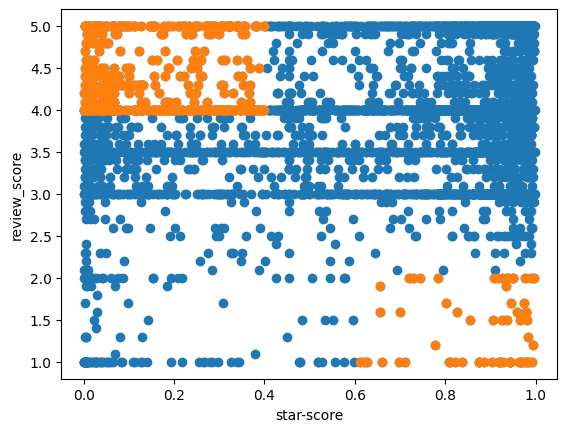

In [17]:
X1 = np.array(total_score)
X2 = np.array(total_review)
x = np.array([X1,X2])

plt.scatter(X2,X1)
plt.scatter(odds['review_score'], odds['score'])
plt.xlabel('star-score')
plt.ylabel('review_score')
plt.show()

In [25]:
odds.head()

,document,score,review_score,most_words,Pos_Neu_Neg
1,이사오기전 회사 앞이라 가끔 갔는데 먹기도 힘들지만 난 화장실도 힘들었던 ㅋㅋ 근...,1.0,0.9277,"[(기전, 1), (회사, 1), (앞, 1), (가끔, 1), (먹기, 1), (...",긍정
6,김밥집 냉면이200배는 맛있음,1.0,0.9692,"[(김밥, 1), (집, 1), (냉면, 1), (맛있음, 1)]",긍정
10,비냉과물냉두개시켜먹었는데 양념이 맵더라구요 맛은있는데 양념이 몬가 깊은양념맛은 아닌...,5.0,0.1504,"[(양념, 3), (맛, 2), (비냉, 1), (물냉, 1), (개시, 1), (...",부정
15,맛없다고욕하는사람들이해안되요 미친듯이매운곳인데뭐 ㅋㅋ맛이아니라아프러오는곳 ㅋ스트레스...,4.0,0.0125,"[(곳, 2), (맛없다고, 1), (욕, 1), (사람, 1), (이해, 1), ...",부정
29,난 못먹는데 매운걸좋아하는데 여기는 그냥심하게아픈맛인데 근데 또가고싶은데??잉?,5.0,0.1107,"[(난, 1), (매운, 1), (걸, 1), (좋아하는데, 1), (그냥, 1),...",부정


#### 긍정(Pos), 중립(Neu), 부정(Neg) 

* 0.66 <= review_score < 1.0 : 긍정
* 0.33 < review_score < 0.66 : 중립
* 0 < review_score < 0.33: 부정

In [19]:
for menu in data_list:
  globals()['data_{}'.format(menu)]['Pos_Neu_Neg'] = ["긍정" if s >=0.66 else "부정" if s <=0.33 else "중립" for s in globals()['data_{}'.format(menu)]['review_score']]
  globals()['data_{}'.format(menu)].to_csv(f'{menu}.csv')       # 경로 변경 후 저장

### 최빈 단어 찾기

In [20]:
from collections import defaultdict

for menu in data_list:
  globals()['dic_{}'.format(menu)] = defaultdict(int)
  for idx in range(len(globals()['data_{}'.format(menu)]['most_words'].tolist())-1):
    word_count = globals()['data_{}'.format(menu)]['most_words'].tolist()[idx]
    for j in range(len(word_count)):  
      word = word_count[j][0]
      globals()['dic_{}'.format(menu)][f'{word}'] += word_count[j][1]
  globals()['dic_{}'.format(menu)] = sorted(globals()['dic_{}'.format(menu)].items(), key=lambda x: x[1], reverse=True)
  globals()['dic_frame_{}'.format(menu)] = pd.DataFrame( globals()['dic_{}'.format(menu)])

In [21]:
print(dic_한식)

[('맛', 218), ('냉면', 117), ('고기', 95), ('곳', 79), ('만두', 75), ('집', 64), ('칼국수', 63), ('맛있어요', 55), ('맛집', 54), ('음식', 52), ('가격', 52), ('정말', 52), ('두부', 47), ('추천', 46), ('진짜', 46), ('육수', 45), ('교자', 45), ('국물', 44), ('사람', 39), ('더', 38), ('때', 37), ('순두부', 36), ('것', 35), ('여기', 34), ('합', 32), ('맛있게', 30), ('메뉴', 30), ('반찬', 30), ('평양', 30), ('좋아요', 29), ('좋고', 29), ('분위기', 28), ('직원', 28), ('명동', 28), ('같아요', 27), ('강남', 27), ('방문', 27), ('전복', 27), ('최고', 26), ('또', 25), ('좀', 25), ('좋은', 25), ('김치', 25), ('저', 24), ('입', 24), ('생각', 24), ('가족', 24), ('입니다', 24), ('양', 23), ('정도', 23), ('하나', 23), ('매운', 22), ('분', 22), ('전', 21), ('식사', 21), ('밥', 21), ('수', 21), ('감자탕', 21), ('비냉', 20), ('있는', 20), ('입맛', 20), ('매장', 20), ('봉피', 20), ('양념', 19), ('제', 19), ('비지', 19), ('주문', 19), ('돼지갈비', 19), ('면', 18), ('먹기', 17), ('기분', 17), ('물냉', 17), ('자주', 17), ('요리', 17), ('다른', 17), ('친구', 17), ('아주', 17), ('알', 17), ('좋았어요', 16), ('시간', 16), ('별로', 16), ('재료', 16), ('안', 16), ('식당', 

In [22]:
# dic_메뉴.csv 저장
for menu in data_list:
  globals()['dic_{}'.format(menu)] = pd.DataFrame(globals()['dic_{}'.format(menu)])
  globals()['dic_{}'.format(menu)] = globals()['dic_{}'.format(menu)].head(10)
  globals()['dic_{}'.format(menu)].to_csv(f'dic_{menu}.csv')